
SumSquares: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 30.5 MB/s 
     |████████████████████████████████| 872 kB 64.0 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=1fafea6dd3edddb43574c6e999f20affb3b5a63f66bd75cbe89cd8edd2051657
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=00d488d464d28b617280c358f35f8d067ac25281c8a524ec40856be99e07827b
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm, t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'SumSquares'
n_test = 500
eps = 1e-08

util_gp = 'CBM_gp'
util_stp = 'CBM_stp'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Sum Squares(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )
        
# Constraints:
lb = -5.12
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds   

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM_stp': self.CBM_stp,
            'CBM_gp': self.CBM_gp,
        }

        self.f = mode_dict[mode]
    
    def CBM_stp(self, y_global_orig, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)

    def CBM_gp(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_gp(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO - Gaussian:

class dGPGO_gp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO - Student's-t:

class dGPGO_stp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_gp = time.time()
start_gp


1663689375.0951605

In [13]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_gp_1 = dGaussianProcess(cov_func, optimize=opt)

gp_1 = dGPGO_gp(surrogate_gp_1, Acquisition_grad(util_gp), objfunc, param)
gp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.84969467  2.25612281]	 10.902161328666502	 1.4334486961549602	    	    
init	 [-5.1188288  -2.02411446]	 34.396486966857985	 1.4334486961549602	    	    
init	 [-3.61721968 -4.17445279]	 47.936390383803385	 1.4334486961549602	    	    
init	 [-3.21269544 -1.58145816]	 15.323431753768267	 1.4334486961549602	    	    
init	 [-1.05710106  0.39748336]	 1.4334486961549602	 1.4334486961549602	    	    
1  	 [ 4.04077223 -4.24914728]	 52.43834538835027	 1.4334486961549602	 3.7778228547599544	 4.2224605242478175
2  	 [5.12 5.12]	 78.64320000000001	 1.4334486961549602	 3.2967915119865627	 3.45116625989047
3  	 [4.21548335 0.41872488]	 18.120960907123376	 1.4334486961549602	 3.2875109764287003	 4.065240147035009
4  	 [-4.89975529  4.58704567]	 66.08957781470292	 1.4334486961549602	 3.676897112128914	 4.408360514968948
5  	 [ 0.61948531 -1.98284995]	 8.2471499372117	 1.43344

In [14]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_gp_2 = dGaussianProcess(cov_func, optimize=opt)

gp_2 = dGPGO_gp(surrogate_gp_2, Acquisition_grad(util_gp), objfunc, param)
gp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 47.562204422038214	 1.1358959044973735	    	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959044973735	 1.1358959044973735	    	    
init	 [-0.81543371 -1.73737143]	 6.7018511217540135	 1.1358959044973735	    	    
init	 [-3.02439799  1.2213347 ]	 12.13030006303276	 1.1358959044973735	    	    
init	 [-2.05153614 -2.3876887 ]	 15.610915224537823	 1.1358959044973735	    	    
1  	 [5.12 5.12]	 78.64320000000001	 1.1358959044973735	 3.7892388851074554	 3.7662184520462443
2  	 [ 4.8426335  -3.96514352]	 54.89582551465308	 1.1358959044973735	 2.8446809099494663	 3.858521070246223
3  	 [-0.18410764  5.12      ]	 52.46269562160627	 1.1358959044973735	 3.6173045636857593	 3.9512150693842507
4  	 [4.19077773 0.54915329]	 18.1657566332978	 1.1358959044973735	 3.5606987784108215	 3.7247671332780388
5  	 [-5.12 -5.12]	 78.64320000000001	 1.13589590449737

In [15]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_gp_3 = dGaussianProcess(cov_func, optimize=opt)

gp_3 = dGPGO_gp(surrogate_gp_3, Acquisition_grad(util_gp), objfunc, param)
gp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 9.356596638100186	 4.609047504113831	    	    
init	 [-2.14113547  0.11087468]	 4.609047504113831	 4.609047504113831	    	    
init	 [4.02377681 4.05804123]	 49.12617709674532	 4.609047504113831	    	    
init	 [-3.83400642 -2.99783293]	 32.673609761904345	 4.609047504113831	    	    
init	 [-4.59297584 -0.6061072 ]	 21.83015892853491	 4.609047504113831	    	    
1  	 [ 1.78408864 -3.06917197]	 22.02260548653085	 4.609047504113831	 2.0215034828088396	 3.5940793820200065
2  	 [-3.52883277  4.8553671 ]	 59.60184005245946	 4.609047504113831	 3.2720359591139814	 4.229416691825365
3  	 [ 5.12       -0.36980437]	 26.487910544875255	 4.609047504113831	 3.433064194660835	 3.5712426893659726
4  	 [-1.36753533 -4.89687229]	 49.82886931111585	 4.609047504113831	 3.1916334206843517	 3.1348039775018925
5	 [ 1.92126018 -0.03414057]	 3.6935718246895224	 3.69

In [16]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_gp_4 = dGaussianProcess(cov_func, optimize=opt)

gp_4= dGPGO_gp(surrogate_gp_4, Acquisition_grad(util_gp), objfunc, param)
gp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.78238555 0.48365823]	 23.33906213310676	 7.289910254474112	    	    
init	 [4.84028785 2.19971578]	 33.10588541607836	 7.289910254474112	    	    
init	 [ 2.02474316 -2.90724357]	 21.003715175118646	 7.289910254474112	    	    
init	 [ 4.87705042 -5.05620219]	 74.91598187475032	 7.289910254474112	    	    
init	 [-2.52946061 -0.66773471]	 7.289910254474112	 7.289910254474112	    	    
1  	 [-1.14381625  4.6459615 ]	 44.478232151417586	 7.289910254474112	 2.9160797510691396	 3.9188980578213637
2  	 [-5.12 -5.12]	 78.64320000000001	 7.289910254474112	 3.8902618020720725	 3.2142627919617084
3  	 [-1.00170082 -5.12      ]	 53.43220453436583	 7.289910254474112	 3.565445947241208	 3.8897097172375745
4	 [0.61264473 1.13480663]	 2.9509057416763538	 2.9509057416763538	 3.2937003369747035	 3.4723064746683576
5  	 [-5.12        2.43507053]	 38.0735369258125	 2.950905741676353

In [17]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_gp_5 = dGaussianProcess(cov_func, optimize=opt)

gp_5 = dGPGO_gp(surrogate_gp_5, Acquisition_grad(util_gp), objfunc, param)
gp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.84678993  3.79629882]	 36.927982283829365	 2.6327313115208373	    	    
init	 [-3.00319585  4.2865757 ]	 45.76864772649561	 2.6327313115208373	    	    
init	 [-0.11866943  1.14425716]	 2.6327313115208373	 2.6327313115208373	    	    
init	 [2.72289645 0.1886002 ]	 7.485305147100433	 2.6327313115208373	    	    
init	 [-2.08076286 -3.19773462]	 24.780587476435763	 2.6327313115208373	    	    
1  	 [ 4.32895605 -5.09732646]	 70.70533460957368	 2.6327313115208373	 4.528267201507804	 4.672920347580683
2  	 [5.12 5.12]	 78.64320000000001	 2.6327313115208373	 4.370116786326016	 3.86437376633164
3  	 [-5.12       -0.28361729]	 26.375277531204137	 2.6327313115208373	 3.4800947258720436	 3.9029657891520517
4  	 [1.04957342 4.74950662]	 46.217230538970604	 2.6327313115208373	 3.4903222942234096	 3.4489441775969256
5  	 [-5.12 -5.12]	 78.64320000000001	 2.6327313115208373	 

In [18]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_gp_6 = dGaussianProcess(cov_func, optimize=opt)

gp_6 = dGPGO_gp(surrogate_gp_6, Acquisition_grad(util_gp), objfunc, param)
gp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 22.104052359713652	 1.4757178799086357	    	    
init	 [ 3.28938622 -4.69302655]	 54.869058151382724	 1.4757178799086357	    	    
init	 [-4.0175956   0.97333314]	 18.035829177697114	 1.4757178799086357	    	    
init	 [ 0.30532979 -0.83141193]	 1.4757178799086357	 1.4757178799086357	    	    
init	 [-1.68542362  1.25459899]	 5.988690020231891	 1.4757178799086357	    	    
1  	 [5.12 5.12]	 78.64320000000001	 1.4757178799086357	 3.9307728838856155	 3.873249744091932
2  	 [-5.12 -5.12]	 78.64320000000001	 1.4757178799086357	 3.812792528736176	 3.742347723655255
3  	 [0.07208547 5.12      ]	 52.433996315479796	 1.4757178799086357	 3.046519623697188	 3.39410424261363
4  	 [-0.88872987 -4.39263629]	 39.38034795310127	 1.4757178799086357	 3.132317854985749	 3.951745680010879
5  	 [2.37017173 1.77366044]	 11.909456767828065	 1.4757178799086357	 2.

In [19]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_gp_7 = dGaussianProcess(cov_func, optimize=opt)

gp_7 = dGPGO_gp(surrogate_gp_7, Acquisition_grad(util_gp), objfunc, param)
gp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.33860312  2.86636843]	 35.25561298730891	 5.622520458601941	    	    
init	 [-0.63068947  2.28828342]	 10.870251237170722	 5.622520458601941	    	    
init	 [4.8946126  0.39419771]	 24.268016205804518	 5.622520458601941	    	    
init	 [ 0.01147355 -4.38219639]	 38.407422120416236	 5.622520458601941	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622520458601941	 5.622520458601941	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 5.622520458601941	 3.539344733651757	 3.477300629387618
2  	 [3.47377579 5.12      ]	 64.49591821064786	 5.622520458601941	 3.731154161492325	 3.7520142863972996
3  	 [ 4.60106006 -4.08987531]	 54.623913747564956	 5.622520458601941	 3.3252556393628385	 3.7957716520997793
4  	 [-4.02558214 -1.33646422]	 19.777584798449002	 5.622520458601941	 2.8894091457083273	 3.046307140328312
5	 [ 1.26778679 -0.69601852]	 2.576166913998925	 2.576166

In [20]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_gp_8 = dGaussianProcess(cov_func, optimize=opt)

gp_8 = dGPGO_gp(surrogate_gp_8, Acquisition_grad(util_gp), objfunc, param)
gp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.82391708 4.79785639]	 60.661193695854244	 0.1518306274298758	    	    
init	 [3.78055209 0.31596228]	 14.492238445440277	 0.1518306274298758	    	    
init	 [-2.73686192 -5.00327624]	 57.555959528959804	 0.1518306274298758	    	    
init	 [-0.7119993  -0.99992207]	 2.506631309190485	 0.1518306274298758	    	    
init	 [ 0.23218863 -0.22126801]	 0.1518306274298758	 0.1518306274298758	    	    
1  	 [0.03250849 1.99787253]	 7.984046105282057	 0.1518306274298758	 3.068275642883515	 3.872615779416303
2  	 [-5.03492225  2.95509263]	 42.81558690689544	 0.1518306274298758	 3.1196115877785515	 3.501974172698668
3  	 [-4.90184883 -0.99417622]	 26.00489462317207	 0.1518306274298758	 2.889777228485675	 3.5433506684026783
4  	 [ 2.61277115 -4.65789363]	 50.218519140159096	 0.1518306274298758	 3.402312368177738	 4.114857442220754
5  	 [-0.06239824  5.12      ]	 52.4326935406022

In [21]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_gp_9 = dGaussianProcess(cov_func, optimize=opt)

gp_9 = dGPGO_gp(surrogate_gp_9, Acquisition_grad(util_gp), objfunc, param)
gp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138613177506063	 14.00341364504739	    	    
init	 [-0.04328148 -3.74958562]	 28.12065798163534	 14.00341364504739	    	    
init	 [-3.66478248 -2.88195916]	 30.04200788009657	 14.00341364504739	    	    
init	 [-0.83447623 -2.57944404]	 14.00341364504739	 14.00341364504739	    	    
init	 [-4.25922917 -1.58209393]	 23.14707552082245	 14.00341364504739	    	    
1  	 [5.12 5.12]	 78.64320000000001	 14.00341364504739	 3.038373123633067	 3.0192895788417218
2  	 [-0.71921852  4.11475232]	 34.379648651490584	 14.00341364504739	 3.285922674497335	 3.932335739590392
3  	 [ 5.12       -1.23904812]	 29.28488047450378	 14.00341364504739	 3.226773657724961	 4.031869640994351
4	 [1.22313087 0.71910039]	 2.530259866855717	 2.530259866855717	 3.251044531764696	 3.7258201356190805
5  	 [3.49381265 1.8275064 ]	 18.886286109589307	 2.530259866855717	 3.7

In [22]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_gp_10 = dGaussianProcess(cov_func, optimize=opt)

gp_10 = dGPGO_gp(surrogate_gp_10, Acquisition_grad(util_gp), objfunc, param)
gp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 55.886194099964676	 14.855028828430257	    	    
init	 [1.36855793 2.54775176]	 14.855028828430257	 14.855028828430257	    	    
init	 [-0.01528819 -2.81808235]	 15.883409988980564	 14.855028828430257	    	    
init	 [-3.09183626  2.66783449]	 23.79413325191142	 14.855028828430257	    	    
init	 [-3.38830503 -4.2154003 ]	 47.019810427389544	 14.855028828430257	    	    
1  	 [ 5.12      -0.3657871]	 26.482000399224187	 14.855028828430257	 3.620958851180413	 3.7809059221061108
2  	 [5.12 5.12]	 78.64320000000001	 14.855028828430257	 3.2734831545303233	 3.5547622048389935
3  	 [-4.19727264 -0.70772147]	 18.618836936207657	 14.855028828430257	 2.7021117025532284	 3.316180115122098
4	 [-0.98165001  0.3379261 ]	 1.1920248324229814	 1.1920248324229814	 3.552282697174951	 3.6087337529608963
5  	 [ 2.00323692 -0.65307552]	 4.865973408912879	 1.1920

In [23]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_gp_11 = dGaussianProcess(cov_func, optimize=opt)

gp_11 = dGPGO_gp(surrogate_gp_11, Acquisition_grad(util_gp), objfunc, param)
gp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 59.14341502486697	 0.7122141741228657	    	    
init	 [-0.37664229  2.30332343]	 10.752457105378047	 0.7122141741228657	    	    
init	 [-0.81711509 -0.14922651]	 0.7122141741228657	 0.7122141741228657	    	    
init	 [-4.98912446 -0.12931474]	 24.924807467825406	 0.7122141741228657	    	    
init	 [4.52410012 3.59214172]	 46.27444610017016	 0.7122141741228657	    	    
1  	 [ 3.03550212 -4.46785095]	 49.13765732819627	 0.7122141741228657	 3.254381789545812	 3.913987280875641
2  	 [ 2.97957553 -0.30955414]	 9.06951788457425	 0.7122141741228657	 2.5610096435674423	 3.4478908246017754
3  	 [-1.19896852  5.12      ]	 53.86632550764567	 0.7122141741228657	 3.2267661961292857	 4.175395104947636
4  	 [-0.10375752 -2.60231153]	 13.554816238441074	 0.7122141741228657	 2.88046418554187	 3.1167156330961228
5  	 [-3.83094867  2.82596846]	 30.6483631833

In [24]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_gp_12 = dGaussianProcess(cov_func, optimize=opt)

gp_12 = dGPGO_gp(surrogate_gp_12, Acquisition_grad(util_gp), objfunc, param)
gp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.54137249  2.45810889]	 24.62591779447066	 6.112828495563743	    	    
init	 [-2.42365424  0.34549139]	 6.112828495563743	 6.112828495563743	    	    
init	 [-4.97075238  4.28796936]	 61.48174177959852	 6.112828495563743	    	    
init	 [ 4.10332011 -4.77776458]	 62.49130467854858	 6.112828495563743	    	    
init	 [ 4.6791612  -3.71497655]	 49.4966510918416	 6.112828495563743	    	    
1  	 [5.12 5.12]	 78.64320000000001	 6.112828495563743	 3.844578738994418	 3.5638827355856275
2  	 [-5.12 -5.12]	 78.64320000000001	 6.112828495563743	 3.641277157046997	 3.0759541781298547
3  	 [2.21043043 0.79230284]	 6.141490294364116	 6.112828495563743	 2.813737097769883	 2.656842911797133
4  	 [0.42822316 4.67756803]	 43.942660447484435	 6.112828495563743	 2.899032597623214	 3.137211204131393
5  	 [-0.46738349 -4.08945992]	 33.665812191020365	 6.112828495563743	 2.7299389448248

In [25]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_gp_13 = dGaussianProcess(cov_func, optimize=opt)

gp_13 = dGPGO_gp(surrogate_gp_13, Acquisition_grad(util_gp), objfunc, param)
gp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 22.532624345992815	 12.440151302029248	    	    
init	 [3.32061217 4.76927179]	 56.51837198799	 12.440151302029248	    	    
init	 [ 4.83943541 -0.47667971]	 23.87458213765974	 12.440151302029248	    	    
init	 [1.11659482 2.82139151]	 17.16728408945556	 12.440151302029248	    	    
init	 [1.45012065 2.27346667]	 12.440151302029248	 12.440151302029248	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 12.440151302029248	 2.8151834978133445	 3.1560145999618334
2  	 [-4.39199677  2.07568555]	 27.9065766872336	 12.440151302029248	 2.897478946332486	 3.9302763376195506
3	 [-1.87806242 -1.44163556]	 7.683744619418214	 7.683744619418214	 2.9021590135298188	 3.3324957344584223
4  	 [-1.90076453  5.12      ]	 56.04170581690368	 7.683744619418214	 3.051038890329819	 3.7343138833858855
5  	 [-0.53235238 -5.12      ]	 52.71219905292758	 7.68374461941821

In [26]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_gp_14 = dGaussianProcess(cov_func, optimize=opt)

gp_14 = dGPGO_gp(surrogate_gp_14, Acquisition_grad(util_gp), objfunc, param)
gp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.14277984 2.79721013]	 15.669155142359655	 6.942951853664133	    	    
init	 [ 3.7931795  -5.03759925]	 65.14302308089468	 6.942951853664133	    	    
init	 [-1.94830412  4.68586229]	 47.71049977745547	 6.942951853664133	    	    
init	 [ 0.13431513 -1.86076749]	 6.942951853664133	 6.942951853664133	    	    
init	 [ 0.40140736 -2.85434939]	 16.455748743182696	 6.942951853664133	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 6.942951853664133	 4.173909664050681	 4.000919344766778
2  	 [5.12 5.12]	 78.64320000000001	 6.942951853664133	 3.9437513730729985	 3.9856402008446086
3  	 [-5.12        0.36584669]	 26.482087598538893	 6.942951853664133	 2.8718273120833717	 3.6918733073329055
4  	 [4.78912472 0.01214057]	 22.936010403233993	 6.942951853664133	 2.977226463537656	 3.336902972314584
5	 [-1.70498912 -0.02304271]	 2.9080498259817866	 2.9080498259817866	 2.87322325

In [27]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_gp_15 = dGaussianProcess(cov_func, optimize=opt)

gp_15 = dGPGO_gp(surrogate_gp_15, Acquisition_grad(util_gp), objfunc, param)
gp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 34.38169974295086	 5.478261179905657	    	    
init	 [-4.56332069 -1.41784631]	 24.84447200795673	 5.478261179905657	    	    
init	 [-2.29989449  0.3072023 ]	 5.478261179905657	 5.478261179905657	    	    
init	 [-1.9873903  -2.00218256]	 11.967190241167383	 5.478261179905657	    	    
init	 [-3.97576933 -2.5610341 ]	 28.924533081850157	 5.478261179905657	    	    
1  	 [3.74846597 5.12      ]	 66.4797971101931	 5.478261179905657	 3.8558754620668605	 3.7781088597484644
2  	 [-1.6219689  5.12     ]	 55.05958312236552	 5.478261179905657	 2.670848706403374	 3.557330585625552
3	 [1.72968249 0.93594674]	 4.743794118209054	 4.743794118209054	 3.178993116500891	 3.426327120101726
4  	 [-5.12        2.79513483]	 41.83995746021066	 4.743794118209054	 3.1999504188450016	 3.5514615513924466
5  	 [5.12       0.99002152]	 28.17468520649762	 4.7437941182

In [28]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_gp_16 = dGaussianProcess(cov_func, optimize=opt)

gp_16 = dGPGO_gp(surrogate_gp_16, Acquisition_grad(util_gp), objfunc, param)
gp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.141239237549925	 8.141239237549925	    	    
init	 [ 0.51918292 -4.65303603]	 43.571039504503474	 8.141239237549925	    	    
init	 [-1.42613673 -2.83565116]	 18.11570093066862	 8.141239237549925	    	    
init	 [ 1.9325559  -3.44339021]	 27.448644544199137	 8.141239237549925	    	    
init	 [-4.39987336  4.51595121]	 60.146516261103784	 8.141239237549925	    	    
1  	 [5.12 5.12]	 78.64320000000001	 8.141239237549925	 3.9072222393519773	 4.045643184817515
2  	 [5.12       0.06491765]	 26.222828601531006	 8.141239237549925	 3.7221302792939115	 3.661536897896313
3  	 [0.38911302 3.73092189]	 27.990965177956515	 8.141239237549925	 3.6673696223866847	 3.992942812683613
4  	 [-5.12 -5.12]	 78.64320000000001	 8.141239237549925	 3.4207377343051837	 3.6172628879717625
5	 [0.6187243  0.24028994]	 0.4982982675357258	 0.4982982675357258	 2.30927995

In [29]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_gp_17 = dGaussianProcess(cov_func, optimize=opt)

gp_17 = dGPGO_gp(surrogate_gp_17, Acquisition_grad(util_gp), objfunc, param)
gp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.617253458637031	 3.1817562258207746	    	    
init	 [-3.15882714 -4.42470033]	 49.134134969019556	 3.1817562258207746	    	    
init	 [2.93873111 1.60085526]	 13.761615685279608	 3.1817562258207746	    	    
init	 [1.40821398 0.77417363]	 3.1817562258207746	 3.1817562258207746	    	    
init	 [-4.71999574 -1.45598869]	 26.518165900202685	 3.1817562258207746	    	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856025273	 3.1817562258207746	 3.208050149663079	 4.394201464074636
2  	 [-1.2588313  5.12     ]	 54.01345625212898	 3.1817562258207746	 3.1678784472003283	 3.4260369243846656
3  	 [5.12 5.12]	 78.64320000000001	 3.1817562258207746	 3.2680971849471803	 3.3396349757067294
4  	 [ 0.93262888 -3.01505698]	 19.050933864892244	 3.1817562258207746	 3.4139266056535598	 3.698846079531733
5  	 [ 5.12     -0.601041]	 26.936900568382985	 3.181756225

In [30]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_gp_18 = dGaussianProcess(cov_func, optimize=opt)

gp_18 = dGPGO_gp(surrogate_gp_18, Acquisition_grad(util_gp), objfunc, param)
gp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3773200933391867	 2.3773200933391867	    	    
init	 [ 3.87687906 -3.25795609]	 36.25874706055664	 2.3773200933391867	    	    
init	 [3.60686662 2.56139557]	 26.130981366974602	 2.3773200933391867	    	    
init	 [1.70088108 4.99604939]	 52.81401545301259	 2.3773200933391867	    	    
init	 [-2.48864335 -4.83014733]	 52.85399210258478	 2.3773200933391867	    	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666312248	 2.3773200933391867	 3.293945523757251	 3.8829831198785225
2  	 [-2.12753483 -0.3727672 ]	 4.804315202971479	 2.3773200933391867	 3.2744759570198485	 2.96615782466781
3  	 [-1.38387445  2.93403287]	 19.132206278720762	 2.3773200933391867	 4.017641919143601	 3.687226069783995
4  	 [-5.12       -1.70543439]	 32.03141292602187	 2.3773200933391867	 3.825947062417855	 3.7457382188921473
5  	 [ 0.23860927 -2.31579522]	 10.782749385772885

In [31]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_gp_19 = dGaussianProcess(cov_func, optimize=opt)

gp_19 = dGPGO_gp(surrogate_gp_19, Acquisition_grad(util_gp), objfunc, param)
gp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 31.298109376682206	 22.814458446152262	    	    
init	 [-2.59135515 -3.70553152]	 34.17704923320956	 22.814458446152262	    	    
init	 [-1.72598719 -4.27008445]	 39.4462742815243	 22.814458446152262	    	    
init	 [1.76104531 3.13952049]	 22.814458446152262	 22.814458446152262	    	    
init	 [4.9432772  1.38916592]	 28.295553455390152	 22.814458446152262	    	    
1  	 [ 4.30065239 -4.25701793]	 54.740014213612724	 22.814458446152262	 3.4583984911850365	 4.611085550384882
2	 [-0.88068124  0.08134806]	 0.7888344545206423	 0.7888344545206423	 4.065685716768643	 3.836029767907779
3  	 [5.12 5.12]	 78.64320000000001	 0.7888344545206423	 4.198613791586308	 4.042060086077244
4  	 [ 1.559397   -1.10272209]	 4.863711017852858	 0.7888344545206423	 2.9587833480117114	 3.3827932131975884
5  	 [-1.05286586  4.39036818]	 39.659192046325145	 0.78883445

In [32]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_gp_20 = dGaussianProcess(cov_func, optimize=opt)

gp_20 = dGPGO_gp(surrogate_gp_20, Acquisition_grad(util_gp), objfunc, param)
gp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.9024594  4.07258857]	 33.98638835688907	 1.615187047660523	    	    
init	 [4.00927467 3.23417577]	 36.994069169927414	 1.615187047660523	    	    
init	 [-4.75249064  1.96359764]	 30.297598676217497	 1.615187047660523	    	    
init	 [-1.24230715  0.18955208]	 1.615187047660523	 1.615187047660523	    	    
init	 [ 1.61742301 -3.13497377]	 22.27217824772924	 1.615187047660523	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 1.615187047660523	 3.672583466482644	 3.5090539996326644
2  	 [ 5.12       -1.00317263]	 28.227110656820955	 1.615187047660523	 3.314467264588547	 3.592812185444764
3  	 [-2.93716141 -1.85326175]	 15.496075410665163	 1.615187047660523	 2.717517928388737	 3.323250705461711
4  	 [-1.3349965 -5.12     ]	 54.21101564714086	 1.615187047660523	 2.739405134738428	 4.041114520134198
5  	 [-2.83493296  5.12      ]	 60.46564489842326	 1.615187047660523	 2

In [33]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1663689905.4567757

In [34]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_stp_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_1 = dGPGO_stp(surrogate_stp_1, Acquisition_grad(util_stp), objfunc, param)
stp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.84969467  2.25612281]	 10.902161328666502	 1.4334486961549602	    	    
init	 [-5.1188288  -2.02411446]	 34.396486966857985	 1.4334486961549602	    	    
init	 [-3.61721968 -4.17445279]	 47.936390383803385	 1.4334486961549602	    	    
init	 [-3.21269544 -1.58145816]	 15.323431753768267	 1.4334486961549602	    	    
init	 [-1.05710106  0.39748336]	 1.4334486961549602	 1.4334486961549602	    	    
1  	 [ 4.04077223 -4.24914728]	 52.43834538835027	 1.4334486961549602	 3.7008731761352003	 4.3087326913878305
2  	 [5.12 5.12]	 78.64320000000001	 1.4334486961549602	 3.2296960528158283	 3.555571379391213
3  	 [4.70959273 0.38076147]	 22.47022227922833	 1.4334486961549602	 3.401078075968388	 4.15306836727743
4  	 [-4.8996706   4.58713035]	 66.09030177989149	 1.4334486961549602	 3.7531583605981127	 4.158526113535269
5  	 [ 0.63590327 -1.966432  ]	 8.13808255715952	 1.43344

In [35]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_stp_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_2 = dGPGO_stp(surrogate_stp_2, Acquisition_grad(util_stp), objfunc, param)
stp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.6554122  -4.85451539]	 47.562204422038214	 1.1358959044973735	    	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959044973735	 1.1358959044973735	    	    
init	 [-0.81543371 -1.73737143]	 6.7018511217540135	 1.1358959044973735	    	    
init	 [-3.02439799  1.2213347 ]	 12.13030006303276	 1.1358959044973735	    	    
init	 [-2.05153614 -2.3876887 ]	 15.610915224537823	 1.1358959044973735	    	    
1  	 [4.81874241 3.07464552]	 42.12716849729408	 1.1358959044973735	 3.7226596370894165	 3.8356570741408977
2  	 [ 4.84261953 -3.96515749]	 54.8959117832305	 1.1358959044973735	 3.0696938979902955	 4.200952408202244
3  	 [0.02398058 5.12      ]	 52.429375068342196	 1.1358959044973735	 3.707808598931289	 3.9911369455606334
4  	 [-5.12 -5.12]	 78.64320000000001	 1.1358959044973735	 3.5878334504857334	 4.1295169853775855
5  	 [ 3.30320273 -0.43579782]	 11.290987731094598	 1.1

In [36]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_stp_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_3 = dGPGO_stp(surrogate_stp_3, Acquisition_grad(util_stp), objfunc, param)
stp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52017052 2.1314337 ]	 9.356596638100186	 4.609047504113831	    	    
init	 [-2.14113547  0.11087468]	 4.609047504113831	 4.609047504113831	    	    
init	 [4.02377681 4.05804123]	 49.12617709674532	 4.609047504113831	    	    
init	 [-3.83400642 -2.99783293]	 32.673609761904345	 4.609047504113831	    	    
init	 [-4.59297584 -0.6061072 ]	 21.83015892853491	 4.609047504113831	    	    
1  	 [ 2.87042319 -1.98283743]	 16.10261781709846	 4.609047504113831	 2.4542033297197294	 2.782414234048212
2  	 [-3.58469501  4.79950486]	 58.920532130899296	 4.609047504113831	 3.0521860772630576	 4.345096849635581
3  	 [-0.39551444 -2.39689456]	 11.646638720636432	 4.609047504113831	 3.1474051308701805	 3.760761825931482
4  	 [ 1.6766048 -5.12     ]	 55.23980364234082	 4.609047504113831	 3.256134513159541	 3.638655691089937
5  	 [5.12       0.65821962]	 27.080906142431594	 4.609047

In [37]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_stp_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_4 = dGPGO_stp(surrogate_stp_4, Acquisition_grad(util_stp), objfunc, param)
stp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.78238555 0.48365823]	 23.33906213310676	 7.289910254474112	    	    
init	 [4.84028785 2.19971578]	 33.10588541607836	 7.289910254474112	    	    
init	 [ 2.02474316 -2.90724357]	 21.003715175118646	 7.289910254474112	    	    
init	 [ 4.87705042 -5.05620219]	 74.91598187475032	 7.289910254474112	    	    
init	 [-2.52946061 -0.66773471]	 7.289910254474112	 7.289910254474112	    	    
1  	 [-1.26606945  4.52370831]	 42.530805546427885	 7.289910254474112	 2.9118530357697696	 3.9594067935367843
2  	 [-5.12 -5.12]	 78.64320000000001	 7.289910254474112	 4.060029931632224	 3.948370969308176
3  	 [-0.97513937 -5.12      ]	 53.379696791929724	 7.289910254474112	 3.474841164679632	 3.946828407259134
4	 [0.60949718 1.13165908]	 2.9327913630251494	 2.9327913630251494	 3.1054366319794076	 3.5711689570071647
5  	 [-5.12        2.31703282]	 36.951682200430724	 2.932791363025149

In [38]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_stp_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_5 = dGPGO_stp(surrogate_stp_5, Acquisition_grad(util_stp), objfunc, param)
stp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.84678993  3.79629882]	 36.927982283829365	 2.6327313115208373	    	    
init	 [-3.00319585  4.2865757 ]	 45.76864772649561	 2.6327313115208373	    	    
init	 [-0.11866943  1.14425716]	 2.6327313115208373	 2.6327313115208373	    	    
init	 [2.72289645 0.1886002 ]	 7.485305147100433	 2.6327313115208373	    	    
init	 [-2.08076286 -3.19773462]	 24.780587476435763	 2.6327313115208373	    	    
1  	 [ 4.32895605 -5.09732646]	 70.70533460957368	 2.6327313115208373	 4.51748771961911	 4.744920621472449
2  	 [5.12 5.12]	 78.64320000000001	 2.6327313115208373	 4.197146802268138	 3.8381520801736686
3  	 [-5.11261891 -0.26470602]	 26.279010715111728	 2.6327313115208373	 3.4603034044041365	 3.7470487631281246
4  	 [1.05783457 4.86805374]	 48.51490845847114	 2.6327313115208373	 3.432569600035695	 3.456633618363173
5  	 [-5.12 -5.12]	 78.64320000000001	 2.6327313115208373	 3.

In [39]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_stp_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_6 = dGPGO_stp(surrogate_stp_6, Acquisition_grad(util_stp), objfunc, param)
stp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 22.104052359713652	 1.4757178799086357	    	    
init	 [ 3.28938622 -4.69302655]	 54.869058151382724	 1.4757178799086357	    	    
init	 [-4.0175956   0.97333314]	 18.035829177697114	 1.4757178799086357	    	    
init	 [ 0.30532979 -0.83141193]	 1.4757178799086357	 1.4757178799086357	    	    
init	 [-1.68542362  1.25459899]	 5.988690020231891	 1.4757178799086357	    	    
1  	 [5.12 5.12]	 78.64320000000001	 1.4757178799086357	 3.863753466520716	 3.9309632342496323
2  	 [-5.12 -5.12]	 78.64320000000001	 1.4757178799086357	 3.760142234954643	 3.757663965818328
3  	 [0.07826141 5.12      ]	 52.43492484808627	 1.4757178799086357	 3.0762444310120456	 3.4432260917736097
4  	 [-0.88950003 -4.39340644]	 39.395250659261976	 1.4757178799086357	 3.1120253638488147	 4.174385649739714
5  	 [2.37800356 1.78149227]	 12.002330371568213	 1.4757178799086357

In [40]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_stp_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_7 = dGPGO_stp(surrogate_stp_7, Acquisition_grad(util_stp), objfunc, param)
stp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.33860312  2.86636843]	 35.25561298730891	 5.622520458601941	    	    
init	 [-0.63068947  2.28828342]	 10.870251237170722	 5.622520458601941	    	    
init	 [4.8946126  0.39419771]	 24.268016205804518	 5.622520458601941	    	    
init	 [ 0.01147355 -4.38219639]	 38.407422120416236	 5.622520458601941	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622520458601941	 5.622520458601941	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 5.622520458601941	 3.4821722731305016	 3.81607011937891
2  	 [3.5599965 5.12     ]	 65.10237505076962	 5.622520458601941	 3.7289412160684146	 4.068090637595679
3  	 [ 4.60098855 -4.08994682]	 54.62442556920254	 5.622520458601941	 3.534130660348399	 4.064539243773726
4  	 [-4.02558214 -1.33646422]	 19.777584798449002	 5.622520458601941	 2.8877933811840903	 3.046307140328312
5	 [ 1.26968012 -0.69412519]	 2.5757071753880068	 2.5757071753

In [41]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_stp_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_8 = dGPGO_stp(surrogate_stp_8, Acquisition_grad(util_stp), objfunc, param)
stp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.82391708 4.79785639]	 60.661193695854244	 0.1518306274298758	    	    
init	 [3.78055209 0.31596228]	 14.492238445440277	 0.1518306274298758	    	    
init	 [-2.73686192 -5.00327624]	 57.555959528959804	 0.1518306274298758	    	    
init	 [-0.7119993  -0.99992207]	 2.506631309190485	 0.1518306274298758	    	    
init	 [ 0.23218863 -0.22126801]	 0.1518306274298758	 0.1518306274298758	    	    
1  	 [ 4.9638213  -4.82579675]	 71.21615052930461	 0.1518306274298758	 3.181704326151952	 3.8926961609680726
2  	 [-1.15161962  3.15654216]	 21.253744576220683	 0.1518306274298758	 3.2874907241855498	 3.5348668072105225
3  	 [-5.12      -0.0227532]	 26.215435416649267	 0.1518306274298758	 3.210282148474319	 3.625618103378211
4  	 [ 1.08908556 -4.7860345 ]	 46.99835990052029	 0.1518306274298758	 3.4254177691330217	 3.6068073180088565
5  	 [1.54455205 1.75797313]	 8.566580112347

In [42]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_stp_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_9 = dGPGO_stp(surrogate_stp_9, Acquisition_grad(util_stp), objfunc, param)
stp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138613177506063	 14.00341364504739	    	    
init	 [-0.04328148 -3.74958562]	 28.12065798163534	 14.00341364504739	    	    
init	 [-3.66478248 -2.88195916]	 30.04200788009657	 14.00341364504739	    	    
init	 [-0.83447623 -2.57944404]	 14.00341364504739	 14.00341364504739	    	    
init	 [-4.25922917 -1.58209393]	 23.14707552082245	 14.00341364504739	    	    
1  	 [3.11029524 4.9495987 ]	 58.67099112867045	 14.00341364504739	 2.9711881271891296	 3.055576067503663
2  	 [ 4.90504753 -1.17876654]	 26.83847240486325	 14.00341364504739	 3.5644401887858885	 4.217380336498297
3  	 [-1.94955     3.97847316]	 35.45724266891718	 14.00341364504739	 2.7537757753186294	 4.349630372510881
4	 [1.18383481 0.90690391]	 3.0464142531296106	 3.0464142531296106	 3.3749617311170494	 3.8788455474011645
5  	 [5.12       2.10802882]	 35.10197104412161	 3.04641

In [43]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_stp_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_10 = dGPGO_stp(surrogate_stp_10, Acquisition_grad(util_stp), objfunc, param)
stp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 55.886194099964676	 14.855028828430257	    	    
init	 [1.36855793 2.54775176]	 14.855028828430257	 14.855028828430257	    	    
init	 [-0.01528819 -2.81808235]	 15.883409988980564	 14.855028828430257	    	    
init	 [-3.09183626  2.66783449]	 23.79413325191142	 14.855028828430257	    	    
init	 [-3.38830503 -4.2154003 ]	 47.019810427389544	 14.855028828430257	    	    
1  	 [ 5.12       -0.29097273]	 26.38373026399148	 14.855028828430257	 3.4854530163991013	 3.942610308815784
2  	 [5.12 5.12]	 78.64320000000001	 14.855028828430257	 3.2242335721682447	 4.040945302626161
3  	 [-4.19746119 -0.70791002]	 18.62095366395576	 14.855028828430257	 2.973737324977334	 3.616184239166483
4  	 [0.31218475 5.12      ]	 52.52625931776509	 14.855028828430257	 3.559618100398991	 4.026178903028099
5	 [ 2.05201974 -0.72277365]	 5.255588487977695	 5.2555884879

In [44]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_stp_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_11 = dGPGO_stp(surrogate_stp_11, Acquisition_grad(util_stp), objfunc, param)
stp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.27403839 -4.92057353]	 59.14341502486697	 0.7122141741228657	    	    
init	 [-0.37664229  2.30332343]	 10.752457105378047	 0.7122141741228657	    	    
init	 [-0.81711509 -0.14922651]	 0.7122141741228657	 0.7122141741228657	    	    
init	 [-4.98912446 -0.12931474]	 24.924807467825406	 0.7122141741228657	    	    
init	 [4.52410012 3.59214172]	 46.27444610017016	 0.7122141741228657	    	    
1  	 [ 3.03550212 -4.46785095]	 49.13765732819627	 0.7122141741228657	 3.1035995091347974	 4.044521014703599
2  	 [ 4.91189948 -0.58768239]	 24.81749767398037	 0.7122141741228657	 2.411754952384814	 3.5975117603033073
3  	 [-0.33340839 -2.50917311]	 12.703060536277631	 0.7122141741228657	 3.089374228055466	 4.108972636825099
4  	 [1.77987122 0.55485576]	 3.7836714070167043	 0.7122141741228657	 2.9594734270389322	 3.362757699386688
5  	 [-3.44598743  3.2109297 ]	 32.4949684170

In [45]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_stp_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_12 = dGPGO_stp(surrogate_stp_12, Acquisition_grad(util_stp), objfunc, param)
stp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.54137249  2.45810889]	 24.62591779447066	 6.112828495563743	    	    
init	 [-2.42365424  0.34549139]	 6.112828495563743	 6.112828495563743	    	    
init	 [-4.97075238  4.28796936]	 61.48174177959852	 6.112828495563743	    	    
init	 [ 4.10332011 -4.77776458]	 62.49130467854858	 6.112828495563743	    	    
init	 [ 4.6791612  -3.71497655]	 49.4966510918416	 6.112828495563743	    	    
1  	 [5.12 5.12]	 78.64320000000001	 6.112828495563743	 3.70525138073332	 3.5890171096045487
2  	 [-5.12 -5.12]	 78.64320000000001	 6.112828495563743	 3.519141116263871	 3.1028490357191716
3  	 [2.21730335 0.79917576]	 6.193797948244214	 6.112828495563743	 2.7920507847437523	 2.622575274301577
4  	 [0.43153113 4.680876  ]	 44.00741940460637	 6.112828495563743	 3.046658761400657	 3.2020627730338176
5  	 [-0.47553297 -4.0976094 ]	 33.80693722635099	 6.112828495563743	 2.73036070724115

In [46]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_stp_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_13 = dGPGO_stp(surrogate_stp_13, Acquisition_grad(util_stp), objfunc, param)
stp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 22.532624345992815	 12.440151302029248	    	    
init	 [3.32061217 4.76927179]	 56.51837198799	 12.440151302029248	    	    
init	 [ 4.83943541 -0.47667971]	 23.87458213765974	 12.440151302029248	    	    
init	 [1.11659482 2.82139151]	 17.16728408945556	 12.440151302029248	    	    
init	 [1.45012065 2.27346667]	 12.440151302029248	 12.440151302029248	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 12.440151302029248	 2.8771607054960304	 3.3452476784558707
2  	 [-3.78383095  0.46019358]	 14.740932961079894	 12.440151302029248	 2.9122250422419085	 3.877862851607802
3  	 [-3.12721081  5.12      ]	 62.20824742774508	 12.440151302029248	 3.224860176199335	 3.9883883162307776
4  	 [-1.32563844 -2.6913926 ]	 16.244505519777412	 12.440151302029248	 2.922579517714562	 3.4120526161668385
5  	 [ 0.6603903 -5.12     ]	 52.86491534376137	 12.440151302

In [47]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_stp_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_14 = dGPGO_stp(surrogate_stp_14, Acquisition_grad(util_stp), objfunc, param)
stp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.14277984 2.79721013]	 15.669155142359655	 6.942951853664133	    	    
init	 [ 3.7931795  -5.03759925]	 65.14302308089468	 6.942951853664133	    	    
init	 [-1.94830412  4.68586229]	 47.71049977745547	 6.942951853664133	    	    
init	 [ 0.13431513 -1.86076749]	 6.942951853664133	 6.942951853664133	    	    
init	 [ 0.40140736 -2.85434939]	 16.455748743182696	 6.942951853664133	    	    
1  	 [-5.12       -4.58778325]	 68.30991022720609	 6.942951853664133	 4.219686036193056	 4.01591062524418
2  	 [5.12 5.12]	 78.64320000000001	 6.942951853664133	 3.7941901120824704	 3.9739313963162743
3  	 [ 4.95177313 -0.00993447]	 24.52025449935371	 6.942951853664133	 2.688832269743961	 3.728153170484315
4  	 [-5.12       0.6564111]	 27.076151075346715	 6.942951853664133	 2.5441752095700596	 3.516652073276272
5	 [-1.73248358 -0.05869406]	 3.0083893346724078	 3.0083893346724078	 2

In [48]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_stp_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_15 = dGPGO_stp(surrogate_stp_15, Acquisition_grad(util_stp), objfunc, param)
stp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 34.38169974295086	 5.478261179905657	    	    
init	 [-4.56332069 -1.41784631]	 24.84447200795673	 5.478261179905657	    	    
init	 [-2.29989449  0.3072023 ]	 5.478261179905657	 5.478261179905657	    	    
init	 [-1.9873903  -2.00218256]	 11.967190241167383	 5.478261179905657	    	    
init	 [-3.97576933 -2.5610341 ]	 28.924533081850157	 5.478261179905657	    	    
1  	 [5.12 5.12]	 78.64320000000001	 5.478261179905657	 3.8631684708390273	 3.7699910491942146
2  	 [-0.52159617  5.12      ]	 52.700862563303	 5.478261179905657	 2.6964732976028394	 3.5650774839343162
3  	 [-5.12       3.5639795]	 51.6182997158118	 5.478261179905657	 3.3753859621602467	 3.5596032842885754
4  	 [2.7607564  1.03766607]	 9.77527763904081	 5.478261179905657	 2.9778547871657044	 3.1095196948855337
5  	 [-0.73563025 -5.12      ]	 52.9699518599901	 5.478261179905657	 3

In [49]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_stp_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_16 = dGPGO_stp(surrogate_stp_16, Acquisition_grad(util_stp), objfunc, param)
stp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.141239237549925	 8.141239237549925	    	    
init	 [ 0.51918292 -4.65303603]	 43.571039504503474	 8.141239237549925	    	    
init	 [-1.42613673 -2.83565116]	 18.11570093066862	 8.141239237549925	    	    
init	 [ 1.9325559  -3.44339021]	 27.448644544199137	 8.141239237549925	    	    
init	 [-4.39987336  4.51595121]	 60.146516261103784	 8.141239237549925	    	    
1  	 [5.12     4.933839]	 74.89993460068115	 8.141239237549925	 3.834313672302805	 4.051839862725708
2  	 [ 5.12       -0.04362498]	 26.21820627770274	 8.141239237549925	 3.788087625081063	 3.6510996666678013
3  	 [0.53006503 3.19040212]	 20.638300310142338	 8.141239237549925	 3.5240705898192406	 3.9251669090998584
4  	 [-5.12 -5.12]	 78.64320000000001	 8.141239237549925	 3.700416903419836	 3.83623285623816
5	 [ 1.68913448 -0.14039119]	 2.8925946473365154	 2.8925946473365154	 2.

In [50]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_stp_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_17 = dGPGO_stp(surrogate_stp_17, Acquisition_grad(util_stp), objfunc, param)
stp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.617253458637031	 3.1817562258207746	    	    
init	 [-3.15882714 -4.42470033]	 49.134134969019556	 3.1817562258207746	    	    
init	 [2.93873111 1.60085526]	 13.761615685279608	 3.1817562258207746	    	    
init	 [1.40821398 0.77417363]	 3.1817562258207746	 3.1817562258207746	    	    
init	 [-4.71999574 -1.45598869]	 26.518165900202685	 3.1817562258207746	    	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856025273	 3.1817562258207746	 3.317405810276919	 4.528874912798612
2  	 [-1.28198142  5.12      ]	 54.072276364866326	 3.1817562258207746	 3.2926199180947617	 3.4433395798557096
3  	 [5.12 5.12]	 78.64320000000001	 3.1817562258207746	 3.3610686981761915	 3.265729139897441
4  	 [ 0.92434253 -3.02334333]	 19.13561895653079	 3.1817562258207746	 3.562684584317951	 3.85683179889375
5  	 [ 5.12       -0.68465866]	 27.151914972499764	 3.181756

In [51]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_stp_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_18 = dGPGO_stp(surrogate_stp_18, Acquisition_grad(util_stp), objfunc, param)
stp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3773200933391867	 2.3773200933391867	    	    
init	 [ 3.87687906 -3.25795609]	 36.25874706055664	 2.3773200933391867	    	    
init	 [3.60686662 2.56139557]	 26.130981366974602	 2.3773200933391867	    	    
init	 [1.70088108 4.99604939]	 52.81401545301259	 2.3773200933391867	    	    
init	 [-2.48864335 -4.83014733]	 52.85399210258478	 2.3773200933391867	    	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666312248	 2.3773200933391867	 3.236330767240433	 4.068024368531307
2  	 [-2.13084086 -0.37607323]	 4.823344940312462	 2.3773200933391867	 3.232485722198101	 2.8182984562041717
3  	 [-1.38376331  2.93414401]	 19.133203022937828	 2.3773200933391867	 3.750429071571787	 3.5590918101140607
4  	 [-5.12       -1.68242011]	 31.875474851157758	 2.3773200933391867	 3.257187759048382	 3.824905058508256
5  	 [ 0.21644901 -2.33795549]	 10.97892189649953

In [52]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_stp_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_19 = dGPGO_stp(surrogate_stp_19, Acquisition_grad(util_stp), objfunc, param)
stp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 31.298109376682206	 22.814458446152262	    	    
init	 [-2.59135515 -3.70553152]	 34.17704923320956	 22.814458446152262	    	    
init	 [-1.72598719 -4.27008445]	 39.4462742815243	 22.814458446152262	    	    
init	 [1.76104531 3.13952049]	 22.814458446152262	 22.814458446152262	    	    
init	 [4.9432772  1.38916592]	 28.295553455390152	 22.814458446152262	    	    
1  	 [ 4.82675179 -3.73091852]	 51.13703891504524	 22.814458446152262	 3.389631312493914	 4.613341214120224
2	 [-0.87136671  0.09066259]	 0.7757193515012067	 0.7757193515012067	 4.027311406216385	 3.7435010632027863
3  	 [5.12 5.12]	 78.64320000000001	 0.7757193515012067	 3.976832878812694	 4.058827068705114
4  	 [-5.12       -1.17787248]	 28.989167176886905	 0.7757193515012067	 2.916014847193086	 3.3603108323947444
5  	 [ 1.58357484 -0.8471282 ]	 3.9429616515857457	 0.775719351

In [53]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_stp_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_20 = dGPGO_stp(surrogate_stp_20, Acquisition_grad(util_stp), objfunc, param)
stp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.9024594  4.07258857]	 33.98638835688907	 1.615187047660523	    	    
init	 [4.00927467 3.23417577]	 36.994069169927414	 1.615187047660523	    	    
init	 [-4.75249064  1.96359764]	 30.297598676217497	 1.615187047660523	    	    
init	 [-1.24230715  0.18955208]	 1.615187047660523	 1.615187047660523	    	    
init	 [ 1.61742301 -3.13497377]	 22.27217824772924	 1.615187047660523	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 1.615187047660523	 3.5343101792954763	 3.9773109476824247
2  	 [ 5.12       -0.98995265]	 28.174412492981	 1.615187047660523	 3.1128428897460334	 3.8602299329913525
3  	 [-2.70067585 -2.08351482]	 15.97571801585449	 1.615187047660523	 3.0632396592907605	 3.6822963654147
4  	 [-2.54678485  4.96998498]	 55.88761447317399	 1.615187047660523	 2.7552061396167464	 3.6791728961602783
5  	 [1.65667521 0.30299399]	 2.9281834815642753	 1.615187047660523	 

In [54]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp


522.89905834198

In [55]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.min(-gp_1.GP.y[0:n_init]),-gp_1.GP.y[n_init:(n_init+iters)]) 
stp_output_1 = np.append(np.min(-stp_1.GP.y[0:n_init]),-stp_1.GP.y[n_init:(n_init+iters)]) 

regret_gp_1 = np.log(gp_output_1 - y_global_orig)
regret_stp_1 = np.log(stp_output_1 - y_global_orig)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-4.311818687097402, -1.9499819789212782)

In [56]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.min(-gp_2.GP.y[0:n_init]),-gp_2.GP.y[n_init:(n_init+iters)]) 
stp_output_2 = np.append(np.min(-stp_2.GP.y[0:n_init]),-stp_2.GP.y[n_init:(n_init+iters)]) 

regret_gp_2 = np.log(gp_output_2 - y_global_orig)
regret_stp_2 = np.log(stp_output_2 - y_global_orig)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(-4.458624699374222, 0.12742168273537824)

In [57]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.min(-gp_3.GP.y[0:n_init]),-gp_3.GP.y[n_init:(n_init+iters)]) 
stp_output_3 = np.append(np.min(-stp_3.GP.y[0:n_init]),-stp_3.GP.y[n_init:(n_init+iters)]) 

regret_gp_3 = np.log(gp_output_3 - y_global_orig)
regret_stp_3 = np.log(stp_output_3 - y_global_orig)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3

(-2.5124550199947824, -2.301578685698134)

In [58]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.min(-gp_4.GP.y[0:n_init]),-gp_4.GP.y[n_init:(n_init+iters)]) 
stp_output_4 = np.append(np.min(-stp_4.GP.y[0:n_init]),-stp_4.GP.y[n_init:(n_init+iters)]) 

regret_gp_4 = np.log(gp_output_4 - y_global_orig)
regret_stp_4 = np.log(stp_output_4 - y_global_orig)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4

(-2.844076236232718, 0.294844115856266)

In [59]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.min(-gp_5.GP.y[0:n_init]),-gp_5.GP.y[n_init:(n_init+iters)]) 
stp_output_5 = np.append(np.min(-stp_5.GP.y[0:n_init]),-stp_5.GP.y[n_init:(n_init+iters)]) 

regret_gp_5 = np.log(gp_output_5 - y_global_orig)
regret_stp_5 = np.log(stp_output_5 - y_global_orig)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5

(-1.0386086057727357, 0.15471490368195104)

In [60]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.min(-gp_6.GP.y[0:n_init]),-gp_6.GP.y[n_init:(n_init+iters)]) 
stp_output_6 = np.append(np.min(-stp_6.GP.y[0:n_init]),-stp_6.GP.y[n_init:(n_init+iters)]) 

regret_gp_6 = np.log(gp_output_6 - y_global_orig)
regret_stp_6 = np.log(stp_output_6 - y_global_orig)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6

(-3.3742327064741664, 0.38914456963575095)

In [61]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.min(-gp_7.GP.y[0:n_init]),-gp_7.GP.y[n_init:(n_init+iters)]) 
stp_output_7 = np.append(np.min(-stp_7.GP.y[0:n_init]),-stp_7.GP.y[n_init:(n_init+iters)]) 

regret_gp_7 = np.log(gp_output_7 - y_global_orig)
regret_stp_7 = np.log(stp_output_7 - y_global_orig)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7

(-2.99659094141645, 0.023384123899664155)

In [62]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.min(-gp_8.GP.y[0:n_init]),-gp_8.GP.y[n_init:(n_init+iters)]) 
stp_output_8 = np.append(np.min(-stp_8.GP.y[0:n_init]),-stp_8.GP.y[n_init:(n_init+iters)]) 

regret_gp_8 = np.log(gp_output_8 - y_global_orig)
regret_stp_8 = np.log(stp_output_8 - y_global_orig)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8

(-5.797968101811946, -1.88498967264663)

In [63]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.min(-gp_9.GP.y[0:n_init]),-gp_9.GP.y[n_init:(n_init+iters)]) 
stp_output_9 = np.append(np.min(-stp_9.GP.y[0:n_init]),-stp_9.GP.y[n_init:(n_init+iters)]) 

regret_gp_9 = np.log(gp_output_9 - y_global_orig)
regret_stp_9 = np.log(stp_output_9 - y_global_orig)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9

(-1.5755189037502568, -1.0982851964072013)

In [64]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.min(-gp_10.GP.y[0:n_init]),-gp_10.GP.y[n_init:(n_init+iters)]) 
stp_output_10 = np.append(np.min(-stp_10.GP.y[0:n_init]),-stp_10.GP.y[n_init:(n_init+iters)]) 

regret_gp_10 = np.log(gp_output_10 - y_global_orig)
regret_stp_10 = np.log(stp_output_10 - y_global_orig)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10

(-4.973073166527979, -0.1966194161738578)

In [65]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.min(-gp_11.GP.y[0:n_init]),-gp_11.GP.y[n_init:(n_init+iters)]) 
stp_output_11 = np.append(np.min(-stp_11.GP.y[0:n_init]),-stp_11.GP.y[n_init:(n_init+iters)]) 

regret_gp_11 = np.log(gp_output_11 - y_global_orig)
regret_stp_11 = np.log(stp_output_11 - y_global_orig)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11

(-3.122227082608447, -0.3393766064509819)

In [66]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.min(-gp_12.GP.y[0:n_init]),-gp_12.GP.y[n_init:(n_init+iters)]) 
stp_output_12 = np.append(np.min(-stp_12.GP.y[0:n_init]),-stp_12.GP.y[n_init:(n_init+iters)]) 

regret_gp_12 = np.log(gp_output_12 - y_global_orig)
regret_stp_12 = np.log(stp_output_12 - y_global_orig)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12

(-4.078203423396232, -0.3356100379169307)

In [67]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.min(-gp_13.GP.y[0:n_init]),-gp_13.GP.y[n_init:(n_init+iters)]) 
stp_output_13 = np.append(np.min(-stp_13.GP.y[0:n_init]),-stp_13.GP.y[n_init:(n_init+iters)]) 

regret_gp_13 = np.log(gp_output_13 - y_global_orig)
regret_stp_13 = np.log(stp_output_13 - y_global_orig)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13

(-3.7867447928341074, -0.41711940061040503)

In [68]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.min(-gp_14.GP.y[0:n_init]),-gp_14.GP.y[n_init:(n_init+iters)]) 
stp_output_14 = np.append(np.min(-stp_14.GP.y[0:n_init]),-stp_14.GP.y[n_init:(n_init+iters)]) 

regret_gp_14 = np.log(gp_output_14 - y_global_orig)
regret_stp_14 = np.log(stp_output_14 - y_global_orig)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14

(-4.290150586422052, -0.3486154190815545)

In [69]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.min(-gp_15.GP.y[0:n_init]),-gp_15.GP.y[n_init:(n_init+iters)]) 
stp_output_15 = np.append(np.min(-stp_15.GP.y[0:n_init]),-stp_15.GP.y[n_init:(n_init+iters)]) 

regret_gp_15 = np.log(gp_output_15 - y_global_orig)
regret_stp_15 = np.log(stp_output_15 - y_global_orig)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15

(-5.830735079598698, -0.7679264928229642)

In [70]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.min(-gp_16.GP.y[0:n_init]),-gp_16.GP.y[n_init:(n_init+iters)]) 
stp_output_16 = np.append(np.min(-stp_16.GP.y[0:n_init]),-stp_16.GP.y[n_init:(n_init+iters)]) 

regret_gp_16 = np.log(gp_output_16 - y_global_orig)
regret_stp_16 = np.log(stp_output_16 - y_global_orig)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16

(-2.760960998358009, -1.623656090226922)

In [71]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.min(-gp_17.GP.y[0:n_init]),-gp_17.GP.y[n_init:(n_init+iters)]) 
stp_output_17 = np.append(np.min(-stp_17.GP.y[0:n_init]),-stp_17.GP.y[n_init:(n_init+iters)]) 

regret_gp_17 = np.log(gp_output_17 - y_global_orig)
regret_stp_17 = np.log(stp_output_17 - y_global_orig)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17

(-4.065100294063326, -0.8357158244095316)

In [72]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.min(-gp_18.GP.y[0:n_init]),-gp_18.GP.y[n_init:(n_init+iters)]) 
stp_output_18 = np.append(np.min(-stp_18.GP.y[0:n_init]),-stp_18.GP.y[n_init:(n_init+iters)]) 

regret_gp_18 = np.log(gp_output_18 - y_global_orig)
regret_stp_18 = np.log(stp_output_18 - y_global_orig)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18

(-3.7861171775604525, -0.11913368547887043)

In [73]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.min(-gp_19.GP.y[0:n_init]),-gp_19.GP.y[n_init:(n_init+iters)]) 
stp_output_19 = np.append(np.min(-stp_19.GP.y[0:n_init]),-stp_19.GP.y[n_init:(n_init+iters)]) 

regret_gp_19 = np.log(gp_output_19 - y_global_orig)
regret_stp_19 = np.log(stp_output_19 - y_global_orig)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19

(-4.362390229222916, -0.5835044076573199)

In [74]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.min(-gp_20.GP.y[0:n_init]),-gp_20.GP.y[n_init:(n_init+iters)]) 
stp_output_20 = np.append(np.min(-stp_20.GP.y[0:n_init]),-stp_20.GP.y[n_init:(n_init+iters)]) 

regret_gp_20 = np.log(gp_output_20 - y_global_orig)
regret_stp_20 = np.log(stp_output_20 - y_global_orig)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20

(-4.893549231759079, 0.479450768952963)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

exact1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp1 = np.asarray(approx1_results[4:5][0])[0]
median_gp1 = np.asarray(approx1_results[9:10][0])[0]
upper_gp1 = np.asarray(approx1_results[14:15][0])[0]

lower_stp1 = np.asarray(exact1_results[4:5][0])[0]
median_stp1 = np.asarray(exact1_results[9:10][0])[0]
upper_stp1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

exact11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp11 = np.asarray(approx11_results[4:5][0])[0]
median_gp11 = np.asarray(approx11_results[9:10][0])[0]
upper_gp11 = np.asarray(approx11_results[14:15][0])[0]

lower_stp11 = np.asarray(exact11_results[4:5][0])[0]
median_stp11 = np.asarray(exact11_results[9:10][0])[0]
upper_stp11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

exact21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp21 = np.asarray(approx21_results[4:5][0])[0]
median_gp21 = np.asarray(approx21_results[9:10][0])[0]
upper_gp21 = np.asarray(approx21_results[14:15][0])[0]

lower_stp21 = np.asarray(exact21_results[4:5][0])[0]
median_stp21 = np.asarray(exact21_results[9:10][0])[0]
upper_stp21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

exact2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp2 = np.asarray(approx2_results[4:5][0])[0]
median_gp2 = np.asarray(approx2_results[9:10][0])[0]
upper_gp2 = np.asarray(approx2_results[14:15][0])[0]

lower_stp2 = np.asarray(exact2_results[4:5][0])[0]
median_stp2 = np.asarray(exact2_results[9:10][0])[0]
upper_stp2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

exact12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp12 = np.asarray(approx12_results[4:5][0])[0]
median_gp12 = np.asarray(approx12_results[9:10][0])[0]
upper_gp12 = np.asarray(approx12_results[14:15][0])[0]

lower_stp12 = np.asarray(exact12_results[4:5][0])[0]
median_stp12 = np.asarray(exact12_results[9:10][0])[0]
upper_stp12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

exact3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp3 = np.asarray(approx3_results[4:5][0])[0]
median_gp3 = np.asarray(approx3_results[9:10][0])[0]
upper_gp3 = np.asarray(approx3_results[14:15][0])[0]

lower_stp3 = np.asarray(exact3_results[4:5][0])[0]
median_stp3 = np.asarray(exact3_results[9:10][0])[0]
upper_stp3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

exact13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp13 = np.asarray(approx13_results[4:5][0])[0]
median_gp13 = np.asarray(approx13_results[9:10][0])[0]
upper_gp13 = np.asarray(approx13_results[14:15][0])[0]

lower_stp13 = np.asarray(exact13_results[4:5][0])[0]
median_stp13 = np.asarray(exact13_results[9:10][0])[0]
upper_stp13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

exact4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp4 = np.asarray(approx4_results[4:5][0])[0]
median_gp4 = np.asarray(approx4_results[9:10][0])[0]
upper_gp4 = np.asarray(approx4_results[14:15][0])[0]

lower_stp4 = np.asarray(exact4_results[4:5][0])[0]
median_stp4 = np.asarray(exact4_results[9:10][0])[0]
upper_stp4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

exact14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp14 = np.asarray(approx14_results[4:5][0])[0]
median_gp14 = np.asarray(approx14_results[9:10][0])[0]
upper_gp14 = np.asarray(approx14_results[14:15][0])[0]

lower_stp14 = np.asarray(exact14_results[4:5][0])[0]
median_stp14 = np.asarray(exact14_results[9:10][0])[0]
upper_stp14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

exact5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp5 = np.asarray(approx5_results[4:5][0])[0]
median_gp5 = np.asarray(approx5_results[9:10][0])[0]
upper_gp5 = np.asarray(approx5_results[14:15][0])[0]

lower_stp5 = np.asarray(exact5_results[4:5][0])[0]
median_stp5 = np.asarray(exact5_results[9:10][0])[0]
upper_stp5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

exact15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp15 = np.asarray(approx15_results[4:5][0])[0]
median_gp15 = np.asarray(approx15_results[9:10][0])[0]
upper_gp15 = np.asarray(approx15_results[14:15][0])[0]

lower_stp15 = np.asarray(exact15_results[4:5][0])[0]
median_stp15 = np.asarray(exact15_results[9:10][0])[0]
upper_stp15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

exact6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp6 = np.asarray(approx6_results[4:5][0])[0]
median_gp6 = np.asarray(approx6_results[9:10][0])[0]
upper_gp6 = np.asarray(approx6_results[14:15][0])[0]

lower_stp6 = np.asarray(exact6_results[4:5][0])[0]
median_stp6 = np.asarray(exact6_results[9:10][0])[0]
upper_stp6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

exact16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp16 = np.asarray(approx16_results[4:5][0])[0]
median_gp16 = np.asarray(approx16_results[9:10][0])[0]
upper_gp16 = np.asarray(approx16_results[14:15][0])[0]

lower_stp16 = np.asarray(exact16_results[4:5][0])[0]
median_stp16 = np.asarray(exact16_results[9:10][0])[0]
upper_stp16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

exact7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp7 = np.asarray(approx7_results[4:5][0])[0]
median_gp7 = np.asarray(approx7_results[9:10][0])[0]
upper_gp7 = np.asarray(approx7_results[14:15][0])[0]

lower_stp7 = np.asarray(exact7_results[4:5][0])[0]
median_stp7 = np.asarray(exact7_results[9:10][0])[0]
upper_stp7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

exact17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp17 = np.asarray(approx17_results[4:5][0])[0]
median_gp17 = np.asarray(approx17_results[9:10][0])[0]
upper_gp17 = np.asarray(approx17_results[14:15][0])[0]

lower_stp17 = np.asarray(exact17_results[4:5][0])[0]
median_stp17 = np.asarray(exact17_results[9:10][0])[0]
upper_stp17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

exact8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp8 = np.asarray(approx8_results[4:5][0])[0]
median_gp8 = np.asarray(approx8_results[9:10][0])[0]
upper_gp8 = np.asarray(approx8_results[14:15][0])[0]

lower_stp8 = np.asarray(exact8_results[4:5][0])[0]
median_stp8 = np.asarray(exact8_results[9:10][0])[0]
upper_stp8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

exact18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp18 = np.asarray(approx18_results[4:5][0])[0]
median_gp18 = np.asarray(approx18_results[9:10][0])[0]
upper_gp18 = np.asarray(approx18_results[14:15][0])[0]

lower_stp18 = np.asarray(exact18_results[4:5][0])[0]
median_stp18 = np.asarray(exact18_results[9:10][0])[0]
upper_stp18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

exact9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp9 = np.asarray(approx9_results[4:5][0])[0]
median_gp9 = np.asarray(approx9_results[9:10][0])[0]
upper_gp9 = np.asarray(approx9_results[14:15][0])[0]

lower_stp9 = np.asarray(exact9_results[4:5][0])[0]
median_stp9 = np.asarray(exact9_results[9:10][0])[0]
upper_stp9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

exact19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp19 = np.asarray(approx19_results[4:5][0])[0]
median_gp19 = np.asarray(approx19_results[9:10][0])[0]
upper_gp19 = np.asarray(approx19_results[14:15][0])[0]

lower_stp19 = np.asarray(exact19_results[4:5][0])[0]
median_stp19 = np.asarray(exact19_results[9:10][0])[0]
upper_stp19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

exact10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp10 = np.asarray(approx10_results[4:5][0])[0]
median_gp10 = np.asarray(approx10_results[9:10][0])[0]
upper_gp10 = np.asarray(approx10_results[14:15][0])[0]

lower_stp10 = np.asarray(exact10_results[4:5][0])[0]
median_stp10 = np.asarray(exact10_results[9:10][0])[0]
upper_stp10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

exact20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp20 = np.asarray(approx20_results[4:5][0])[0]
median_gp20 = np.asarray(approx20_results[9:10][0])[0]
upper_gp20 = np.asarray(approx20_results[14:15][0])[0]

lower_stp20 = np.asarray(exact20_results[4:5][0])[0]
median_stp20 = np.asarray(exact20_results[9:10][0])[0]
upper_stp20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]

In [97]:
### Summarize arrays: 'exact'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]

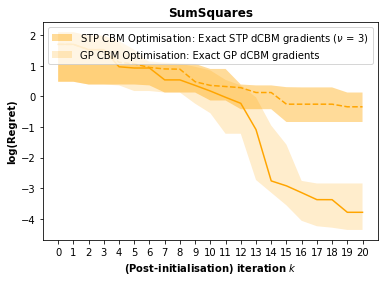

In [122]:
### Visualise!

title = func
plt.figure()

plt.plot(median_stp, color = 'Orange', ls='--')
plt.plot(median_gp, color = 'Orange', ls='-')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Orange', alpha=0.4, label='STP CBM Optimisation: Exact STP dCBM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Orange', alpha=0.2, label='GP CBM Optimisation: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_gp, time_stp


(530.3615136146545, 522.89905834198)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncgp_gp_1 = acqFuncExact(gp_1.history)
acqFuncstp_stp_1 = acqFuncExact(stp_1.history)

e1 = np.std(acqFuncstp_stp_1)
a1 = np.std(acqFuncgp_gp_1)

e1, a1


(0.32348682937485457, 0.3515561177684857)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncgp_gp_2 = acqFuncExact(gp_2.history)
acqFuncstp_stp_2 = acqFuncExact(stp_2.history)

e2 = np.std(acqFuncstp_stp_2)
a2 = np.std(acqFuncgp_gp_2)

e2, a2


(0.3278187395053894, 0.46876390114674565)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncgp_gp_3 = acqFuncExact(gp_3.history)
acqFuncstp_stp_3 = acqFuncExact(stp_3.history)

e3 = np.std(acqFuncstp_stp_3)
a3 = np.std(acqFuncgp_gp_3)

e3, a3


(0.3724904968635358, 0.43498499063033225)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncgp_gp_4 = acqFuncExact(gp_4.history)
acqFuncstp_stp_4 = acqFuncExact(stp_4.history)

e4 = np.std(acqFuncstp_stp_4)
a4 = np.std(acqFuncgp_gp_4)

e4, a4


(0.4166677105635497, 0.3591831327612566)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncgp_gp_5 = acqFuncExact(gp_5.history)
acqFuncstp_stp_5 = acqFuncExact(stp_5.history)

e5 = np.std(acqFuncstp_stp_5)
a5 = np.std(acqFuncgp_gp_5)

e5, a5


(0.6003352224436845, 0.7295728480894144)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncgp_gp_6 = acqFuncExact(gp_6.history)
acqFuncstp_stp_6 = acqFuncExact(stp_6.history)

e6 = np.std(acqFuncstp_stp_6)
a6 = np.std(acqFuncgp_gp_6)

e6, a6


(0.38963741346123215, 0.429261365635169)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncgp_gp_7 = acqFuncExact(gp_7.history)
acqFuncstp_stp_7 = acqFuncExact(stp_7.history)

e7 = np.std(acqFuncstp_stp_7)
a7 = np.std(acqFuncgp_gp_7)

e7, a7


(0.38342953327161006, 0.35937433690437337)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncgp_gp_8 = acqFuncExact(gp_8.history)
acqFuncstp_stp_8 = acqFuncExact(stp_8.history)

e8 = np.std(acqFuncstp_stp_8)
a8 = np.std(acqFuncgp_gp_8)

e8, a8


(0.32690832390039976, 0.3008777051391968)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncgp_gp_9 = acqFuncExact(gp_9.history)
acqFuncstp_stp_9 = acqFuncExact(stp_9.history)

e9 = np.std(acqFuncstp_stp_9)
a9 = np.std(acqFuncgp_gp_9)

e9, a9


(0.3229748158353958, 0.5486726779830936)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncgp_gp_10 = acqFuncExact(gp_10.history)
acqFuncstp_stp_10 = acqFuncExact(stp_10.history)

e10 = np.std(acqFuncstp_stp_10)
a10 = np.std(acqFuncgp_gp_10)

e10, a10


(0.3192542562256944, 0.3224244329218004)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncgp_gp_11 = acqFuncExact(gp_11.history)
acqFuncstp_stp_11 = acqFuncExact(stp_11.history)

e11 = np.std(acqFuncstp_stp_11)
a11 = np.std(acqFuncgp_gp_11)

e11, a11


(0.3444601183280494, 0.408540149582068)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncgp_gp_12 = acqFuncExact(gp_12.history)
acqFuncstp_stp_12 = acqFuncExact(stp_12.history)

e12 = np.std(acqFuncstp_stp_12)
a12 = np.std(acqFuncgp_gp_12)

e12, a12


(0.330236748848563, 0.38243061343048557)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncgp_gp_13 = acqFuncExact(gp_13.history)
acqFuncstp_stp_13 = acqFuncExact(stp_13.history)

e13 = np.std(acqFuncstp_stp_13)
a13 = np.std(acqFuncgp_gp_13)

e13, a13


(0.30944739916572844, 0.2956962007172836)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncgp_gp_14 = acqFuncExact(gp_14.history)
acqFuncstp_stp_14 = acqFuncExact(stp_14.history)

e14 = np.std(acqFuncstp_stp_14)
a14 = np.std(acqFuncgp_gp_14)

e14, a14


(0.44011846035336893, 0.5203377901147203)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncgp_gp_15 = acqFuncExact(gp_15.history)
acqFuncstp_stp_15 = acqFuncExact(stp_15.history)

e15 = np.std(acqFuncstp_stp_15)
a15 = np.std(acqFuncgp_gp_15)

e15, a15


(0.4408873439897162, 0.535717463810094)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncgp_gp_16 = acqFuncExact(gp_16.history)
acqFuncstp_stp_16 = acqFuncExact(stp_16.history)

e16 = np.std(acqFuncstp_stp_16)
a16 = np.std(acqFuncgp_gp_16)

e16, a16


(0.4643018668814715, 0.5799858294654812)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncgp_gp_17 = acqFuncExact(gp_17.history)
acqFuncstp_stp_17 = acqFuncExact(stp_17.history)

e17 = np.std(acqFuncstp_stp_17)
a17 = np.std(acqFuncgp_gp_17)

e17, a17


(0.39125889465166447, 0.3036526303656993)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncgp_gp_18 = acqFuncExact(gp_18.history)
acqFuncstp_stp_18 = acqFuncExact(stp_18.history)

e18 = np.std(acqFuncstp_stp_18)
a18 = np.std(acqFuncgp_gp_18)

e18, a18


(0.45472946945377574, 0.6067351824179593)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncgp_gp_19 = acqFuncExact(gp_19.history)
acqFuncstp_stp_19 = acqFuncExact(stp_19.history)

e19 = np.std(acqFuncstp_stp_19)
a19 = np.std(acqFuncgp_gp_19)

e19, a19


(0.5359760981623028, 0.6082773796219294)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncgp_gp_20 = acqFuncExact(gp_20.history)
acqFuncstp_stp_20 = acqFuncExact(stp_20.history)

e20 = np.std(acqFuncstp_stp_20)
a20 = np.std(acqFuncgp_gp_20)

e20, a20


(0.41271571872373475, 0.29082182619256775)

In [120]:
### Summarize arrays: 

stp_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
gp_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(stp_stddev), np.mean(gp_stddev)


(0.395356773000186, 0.44184332873490784)

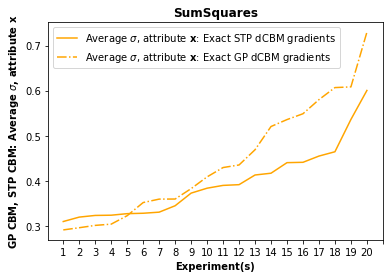

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(stp_stddev, color = 'Orange', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dCBM gradients')
plt.plot(gp_stddev, color = 'Orange', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('GP CBM, STP CBM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualise!
